In [2]:
import os
import json
import numpy as np 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import re
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

import os
        
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm_notebook as tqdm
from Levenshtein import ratio as levenshtein_distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from scipy import spatial

Loading BokehJS ...

In [3]:
## load the data 
df_train = pd.read_csv('/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/CORD-19-research-challenge/metadata.csv')

In [4]:
#Looking data format and types
print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
cord_uid                       51078 non-null object
sha                            38022 non-null object
source_x                       51078 non-null object
title                          50920 non-null object
doi                            47741 non-null object
pmcid                          41082 non-null object
pubmed_id                      37861 non-null float64
license                        51078 non-null object
abstract                       42352 non-null object
publish_time                   51070 non-null object
authors                        48891 non-null object
journal                        46368 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_pdf_parse                  51078 non-null bool
has_pmc_xml_parse              51078 non-null bool
full_text_file                 42511 non-null ob

In [5]:
#Take a look at the data
df_train.head(n=2)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


In [6]:
df_train["title"].head()

0    Airborne rhinovirus detection and effect of ul...
1      Discovering human history from stomach bacteria
2       A new recruit for the army of the men of death
3    Association of HLA class I with severe acute r...
4     A double epidemic model for the SARS propagation
Name: title, dtype: object

In [7]:
q = df_train["title"].to_list()
for i in range(20):
    print('Article title '+str(i+1)+': '+q[i])

Article title 1: Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay
Article title 2: Discovering human history from stomach bacteria
Article title 3: A new recruit for the army of the men of death
Article title 4: Association of HLA class I with severe acute respiratory syndrome coronavirus infection
Article title 5: A double epidemic model for the SARS propagation
Article title 6: Cloaked similarity between HIV-1 and SARS-CoV suggests an anti-SARS strategy
Article title 7: Relationship of SARS-CoV to other pathogenic RNA viruses explored by tetranucleotide usage profiling
Article title 8: Viral Discovery and Sequence Recovery Using DNA Microarrays
Article title 9: A model of tripeptidyl-peptidase I (CLN2), a ubiquitous and highly conserved member of the sedolisin family of serine-carboxyl peptidases
Article title 10: Air pollution and case fatality of SARS in the People's Republic of China: an ecologic study
Article title 11:

In [8]:
# For the Abstract
q = df_train["abstract"].to_list()
q = [x for x in q if str(x) != 'nan']
j=0
for i in q[:20]:
    print('Abstract content '+str(j+1)+': '+i)

Abstract content 1: BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we exposed aerosols to a UV dose of 684 mJ/m(2). Aerosols were collected on Teflon filters and rhinovirus recovered in Qiagen AVL buffer using the Qiagen QIAamp Viral RNA Kit (Qiagen 

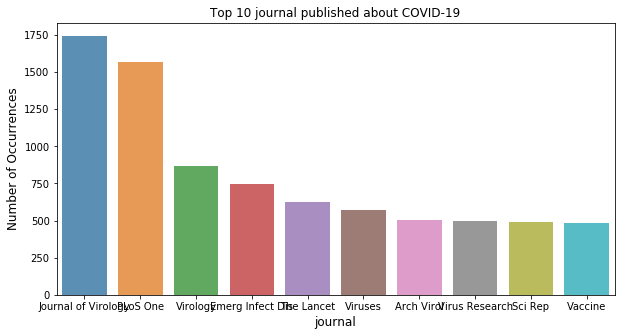

In [9]:
# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
journal_count  = df_train['journal'].value_counts()
journal_count = journal_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(journal_count.index, journal_count.values, alpha=0.8)
plt.title('Top 10 journal published about COVID-19')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('journal', fontsize=12)
plt.show()

In [10]:
# For the Abstract
reindexed_data = df_train["abstract"].dropna()

In [11]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

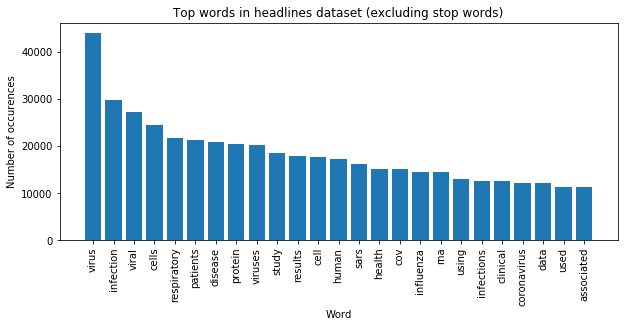

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [13]:
reindexed_data1 = df_train["journal"].dropna()

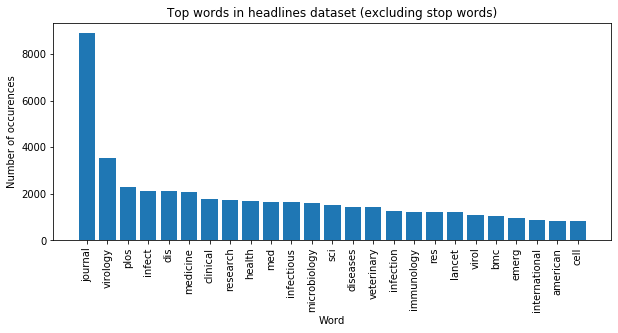

In [14]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data1)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

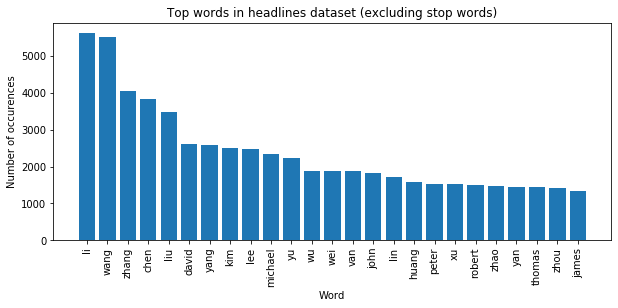

In [15]:
reindexed_data2 = df_train["authors"].dropna()

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data2)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()


In [16]:
# For the Abstract
reindexed_data = df_train["abstract"].dropna().tolist()
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(len(reindexed_data))]

In [17]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per Abstract: ', np.mean(word_counts))

Total number of words:  8365640
Mean number of words per Abstract:  197.52644503211184


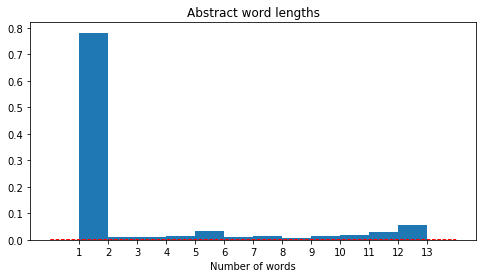

In [18]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Abstract word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

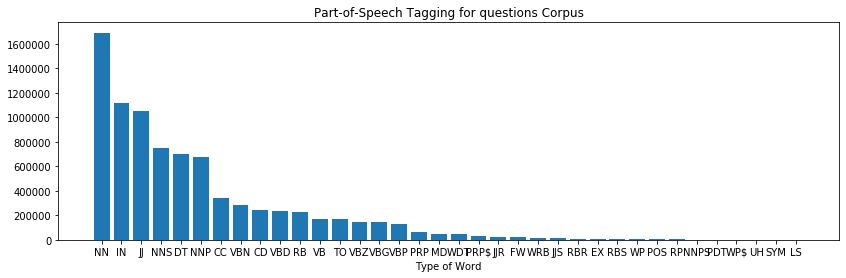

In [19]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for questions Corpus');
ax.set_xlabel('Type of Word');

In [20]:
reindexed_data = df_train["abstract"].dropna()
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=500, random_state=0).values

print('Abstracts before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Abstracts after vectorization: \n{}'.format(small_document_term_matrix[123]))

Abstracts before vectorization: Tuberculosis is a major infectious disease that globally causes the highest human mortality. From this aspect, this study was carried out to evaluate novel pharmacological activities/effects of artesunate and artemisinin causing anti-tubercular activity/effects against Mycobacterium tuberculosis (Mtb). The anti-Mtb activities/effects of artesunate and artemisinin were evaluated using different anti-Mtb indicator assays, such as the resazurin microtiter assay, the Mycobacteria Growth Indicator Tube (MGIT) 960 system assay, and the Ogawa slant medium assay, as well as in vivo tests. Artesunate showed selective anti-Mtb effects by strongly inhibiting the growth of Mtb compared to artemisinin, and consistently induced anti-Mtb activity/effects by effectively inhibiting Mtb in the MGIT 960 system and in Ogawa slant medium for 21 days with a single dose; its minimum inhibitory concentration was 300 µg/mL in in vitro testing. Furthermore, artesunate demonstrate

In [21]:
#number of topics
n_topics = 5

In [22]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [23]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [24]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [25]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [26]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.990178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.411983
[t-SNE] KL divergence after 1950 iterations: 0.582303


In [27]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [28]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [29]:
# Preparing a corpus for analysis and checking the first 5 entries
corpus=[]

corpus = df_train["abstract"].dropna().to_list()

corpus[:2]

['BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we exposed aerosols to a UV dose of 684 mJ/m(2). Aerosols were collected on Teflon filters and rhinovirus recovered in Qiagen AVL buffer using the Qiagen QIAamp Viral RNA Kit (Qiagen Corp., Valencia, C

In [30]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T" will be used to save temporary dictionary and corpus.


In [31]:
# removing common words and tokenizing
# google-quest-challenge
stoplist = stopwords.words('english') + list(punctuation) + list("([)]?") + [")?"]

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'google-quest-challenge.dict'))  # store the dictionary,

2020-04-27 20:16:07,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-27 20:16:09,857 : INFO : adding document #10000 to Dictionary(123275 unique tokens: ['(qiagen', ')of', '1.3', '684', 'adults.']...)
2020-04-27 20:16:12,047 : INFO : adding document #20000 to Dictionary(189505 unique tokens: ['(qiagen', ')of', '1.3', '684', 'adults.']...)
2020-04-27 20:16:14,114 : INFO : adding document #30000 to Dictionary(258095 unique tokens: ['(qiagen', ')of', '1.3', '684', 'adults.']...)
2020-04-27 20:16:16,214 : INFO : adding document #40000 to Dictionary(308759 unique tokens: ['(qiagen', ')of', '1.3', '684', 'adults.']...)
2020-04-27 20:16:16,729 : INFO : built Dictionary(320275 unique tokens: ['(qiagen', ')of', '1.3', '684', 'adults.']...) from 42352 documents (total 5376433 corpus positions)
2020-04-27 20:16:16,730 : INFO : saving Dictionary object under /var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/google-quest-challenge.dict, separately None
2020-04-27 20:16:16,8

In [32]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'google-quest-challenge.mm'), corpus) 

2020-04-27 20:16:21,195 : INFO : storing corpus in Matrix Market format to /var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/google-quest-challenge.mm
2020-04-27 20:16:21,198 : INFO : saving sparse matrix to /var/folders/07/ch803bln2x51cptcxk5bs3gr0000gn/T/google-quest-challenge.mm
2020-04-27 20:16:21,199 : INFO : PROGRESS: saving document #0
2020-04-27 20:16:21,329 : INFO : PROGRESS: saving document #1000
2020-04-27 20:16:21,463 : INFO : PROGRESS: saving document #2000
2020-04-27 20:16:21,586 : INFO : PROGRESS: saving document #3000
2020-04-27 20:16:21,720 : INFO : PROGRESS: saving document #4000
2020-04-27 20:16:21,854 : INFO : PROGRESS: saving document #5000
2020-04-27 20:16:21,988 : INFO : PROGRESS: saving document #6000
2020-04-27 20:16:22,126 : INFO : PROGRESS: saving document #7000
2020-04-27 20:16:22,269 : INFO : PROGRESS: saving document #8000
2020-04-27 20:16:22,403 : INFO : PROGRESS: saving document #9000
2020-04-27 20:16:22,538 : INFO : PROGRESS: saving document #10000
2020-

In [33]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2020-04-27 20:25:15,354 : INFO : collecting document frequencies
2020-04-27 20:25:15,355 : INFO : PROGRESS: processing document #0
2020-04-27 20:25:15,601 : INFO : PROGRESS: processing document #10000
2020-04-27 20:25:15,836 : INFO : PROGRESS: processing document #20000
2020-04-27 20:25:16,060 : INFO : PROGRESS: processing document #30000
2020-04-27 20:25:16,294 : INFO : PROGRESS: processing document #40000
2020-04-27 20:25:16,366 : INFO : calculating IDF weights for 42352 documents and 320275 features (4182660 matrix non-zeros)


In [34]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [35]:
#I will try 15 topics
total_topics = 15

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

2020-04-27 20:26:53,193 : INFO : using symmetric alpha at 0.06666666666666667
2020-04-27 20:26:53,194 : INFO : using symmetric eta at 0.06666666666666667
2020-04-27 20:26:53,247 : INFO : using serial LDA version on this node
2020-04-27 20:26:53,729 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 42352 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-27 20:26:53,732 : INFO : PROGRESS: pass 0, at document #2000/42352
2020-04-27 20:26:55,578 : INFO : merging changes from 2000 documents into a model of 42352 documents
2020-04-27 20:26:55,905 : INFO : topic #1 (0.067): 0.006*"virus" + 0.006*"influenza" + 0.005*"viral" + 0.003*"respiratory" + 0.003*"health" + 0.003*"disease" + 0.003*"pandemic" + 0.003*"infection" + 0.003*"using" + 0.003*"antiviral"
2020-04-27 20:26:55,910 : INFO : topic #4 (0.067): 0.009*"viral" + 0.007*"virus" + 

2020-04-27 20:27:05,854 : INFO : topic #0 (0.067): 0.007*"ace2" + 0.005*"j." + 0.004*"prediction" + 0.004*"f." + 0.004*"de" + 0.004*"using" + 0.003*"study" + 0.003*"angiotensin" + 0.003*"survivors" + 0.003*"care"
2020-04-27 20:27:05,864 : INFO : topic diff=0.155341, rho=0.408248
2020-04-27 20:27:05,874 : INFO : PROGRESS: pass 0, at document #14000/42352
2020-04-27 20:27:07,291 : INFO : merging changes from 2000 documents into a model of 42352 documents
2020-04-27 20:27:07,498 : INFO : topic #2 (0.067): 0.022*"patients" + 0.010*"respiratory" + 0.009*"clinical" + 0.008*"study" + 0.006*"infection" + 0.005*"cases" + 0.005*"among" + 0.005*"associated" + 0.005*"children" + 0.005*"influenza"
2020-04-27 20:27:07,503 : INFO : topic #8 (0.067): 0.013*"infection" + 0.011*"expression" + 0.009*"cells" + 0.009*"genes" + 0.007*"viral" + 0.006*"gene" + 0.006*"cell" + 0.006*"virus" + 0.005*"host" + 0.005*"infection."
2020-04-27 20:27:07,508 : INFO : topic #5 (0.067): 0.008*"virus" + 0.006*"viruses" + 0

2020-04-27 20:27:17,949 : INFO : topic #0 (0.067): 0.059*"de" + 0.030*"en" + 0.019*"ace2" + 0.016*"van" + 0.008*"angiotensin" + 0.005*"f" + 0.005*"prediction" + 0.005*"ang" + 0.005*"enzyme" + 0.005*"ii"
2020-04-27 20:27:17,959 : INFO : topic diff=0.123698, rho=0.288675
2020-04-27 20:27:17,969 : INFO : PROGRESS: pass 0, at document #26000/42352
2020-04-27 20:27:19,112 : INFO : merging changes from 2000 documents into a model of 42352 documents
2020-04-27 20:27:19,318 : INFO : topic #0 (0.067): 0.098*"de" + 0.044*"en" + 0.016*"ace2" + 0.012*"van" + 0.007*"angiotensin" + 0.006*"et" + 0.005*"chapter" + 0.005*"ang" + 0.005*"para" + 0.005*"2020."
2020-04-27 20:27:19,322 : INFO : topic #7 (0.067): 0.016*"pedv" + 0.011*"strains" + 0.010*"strain" + 0.009*"se" + 0.009*"diarrhea" + 0.009*"con" + 0.008*"porcine" + 0.008*"ibv" + 0.005*"epidemic" + 0.005*"la"
2020-04-27 20:27:19,327 : INFO : topic #9 (0.067): 0.009*"abstract" + 0.008*"et" + 0.007*"studies" + 0.006*"peptides" + 0.006*"peptide" + 0.00

2020-04-27 20:27:26,741 : INFO : topic diff=0.042299, rho=0.235702
2020-04-27 20:27:26,750 : INFO : PROGRESS: pass 0, at document #38000/42352
2020-04-27 20:27:27,969 : INFO : merging changes from 2000 documents into a model of 42352 documents
2020-04-27 20:27:28,178 : INFO : topic #10 (0.067): 0.008*"transmission" + 0.008*"data" + 0.008*"disease" + 0.008*"model" + 0.007*"epidemic" + 0.006*"number" + 0.005*"spread" + 0.005*"control" + 0.005*"infectious" + 0.004*"risk"
2020-04-27 20:27:28,183 : INFO : topic #9 (0.067): 0.069*"abstract" + 0.010*"studies" + 0.008*"peptides" + 0.007*"colostrum" + 0.006*"peptide" + 0.005*"et" + 0.005*"review" + 0.003*"delivery" + 0.003*"systematic" + 0.003*"search"
2020-04-27 20:27:28,188 : INFO : topic #2 (0.067): 0.026*"patients" + 0.009*"clinical" + 0.009*"cases" + 0.007*"study" + 0.006*"calves" + 0.006*"infection" + 0.006*"respiratory" + 0.005*"severe" + 0.005*"days" + 0.005*"risk"
2020-04-27 20:27:28,193 : INFO : topic #8 (0.067): 0.017*"expression" + 

In [36]:
lda.show_topics(total_topics,5)

[(0, '0.152*"de" + 0.054*"en" + 0.040*"et" + 0.032*"les" + 0.019*"el"'),
 (1,
  '0.021*"di" + 0.011*"frameshifting" + 0.010*"ribosomal" + 0.008*"frameshift" + 0.006*"pseudoknot"'),
 (2,
  '0.025*"patients" + 0.009*"clinical" + 0.008*"study" + 0.007*"cases" + 0.007*"calves"'),
 (3, '0.145*"abstract" + 0.029*"sars" + 0.011*"los" + 0.007*"(n" + 0.006*"±"'),
 (4,
  '0.040*"respiratory" + 0.021*"virus" + 0.018*"viral" + 0.015*"influenza" + 0.014*"viruses"'),
 (5,
  '0.008*"detection" + 0.007*"used" + 0.007*"assay" + 0.006*"vaccine" + 0.006*"development"'),
 (6,
  '0.012*"virus" + 0.012*"immune" + 0.010*"infection" + 0.009*"mice" + 0.008*"vaccine"'),
 (7, '0.034*"la" + 0.028*"ibv" + 0.023*"pedv" + 0.015*"porcine" + 0.013*"se"'),
 (8,
  '0.021*"expression" + 0.010*"infection" + 0.009*"cancer" + 0.009*"genes" + 0.008*"apoptosis"'),
 (9,
  '0.107*"abstract" + 0.011*"peptides" + 0.010*"studies" + 0.008*"colostrum" + 0.007*"peptide"'),
 (10,
  '0.008*"transmission" + 0.008*"disease" + 0.007*"mode

In [37]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [38]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(15, 272)


In [39]:
df_lda

,de,en,et,les,el,à,ace2,le,las,que,2020.,para,angiotensin,son,hpv,stock,housing,enzyme,angiotensin-converting,macro,ii,plus,orf1a,mr,cardiovascular,di,frameshifting,ribosomal,frameshift,pseudoknot,unfolding,•,3',reading,−1,em,programmed,"service,",frameshifting.,base,sequence,efficiency,thermodynamic,(iii),(iv),ribosome,translational,downstream,(i),(ii),patients,clinical,study,cases,calves,infection,respiratory,hospital,results,associated,treatment,risk,group,severe,pneumonia,days,disease,acute,compared,p,(p,among,higher,age,total,abstract,sars,los,(n,±,serum,bats,igg,fip,temperature,la,sars.,(sars),sars-cov,positive,concentrations,samples,bat,igm,aom,virus,viral,influenza,viruses,infections,children,human,des,detected,tract,common,cause,pcr,detection,coronavirus,syncytial,used,assay,vaccine,development,new,using,vaccines,potential,use,developed,diagnostic,rapid,method,methods,specific,infectious,drug,sensitivity,molecular,immune,mice,response,responses,lung,antibody,induced,infected,levels,infection.,significantly,type,cells,increased,pigs,may,ibv,pedv,porcine,se,diarrhea,bronchitis,con,strain,strains,epidemic,(ibv),piglets,tb,(pedv),n,suckling,s1,economic,ms,chickens,isolates,losses,field,expression,cancer,genes,apoptosis,gene,cell,role,tumor,hbv,dc-sign,t.,activation,host,cells.,peptides,studies,colostrum,peptide,review,systematic,cognitive,nanoparticles,search,rbd,psychiatric,"al.,",databases,delivery,zinc,fusion,literature,digestive,immunoglobulins,dot,articles,disorders,(rbd),transmission,model,data,number,control,spread,air,population,different,based,also,time,outbreak,models,impact,protein,rna,proteins,activity,replication,antiviral,cellular,binding,membrane,structural,domain,structure,health,public,care,research,global,diseases,emergency,management,medical,article,syndrome,international,emerging,prevention,countries,mhv,"cells,",mouse,hepatitis,system,receptor,central,nervous,b,surface,class,two,sequences,analysis,genome,cats,feline,antibodies,three,one,species,amino,showed,found
0,0.15168,0.05424,0.039891,0.0319,0.018721,0.012477,0.011984,0.008683,0.00832,0.008254,0.007515,0.006421,0.004297,0.003423,0.003119,0.003118,0.002979,0.002699,0.002576,0.002551,0.002512,0.00251,0.002267,0.002225,0.002187,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

2020-04-27 20:27:34,943 : INFO : NumExpr defaulting to 4 threads.


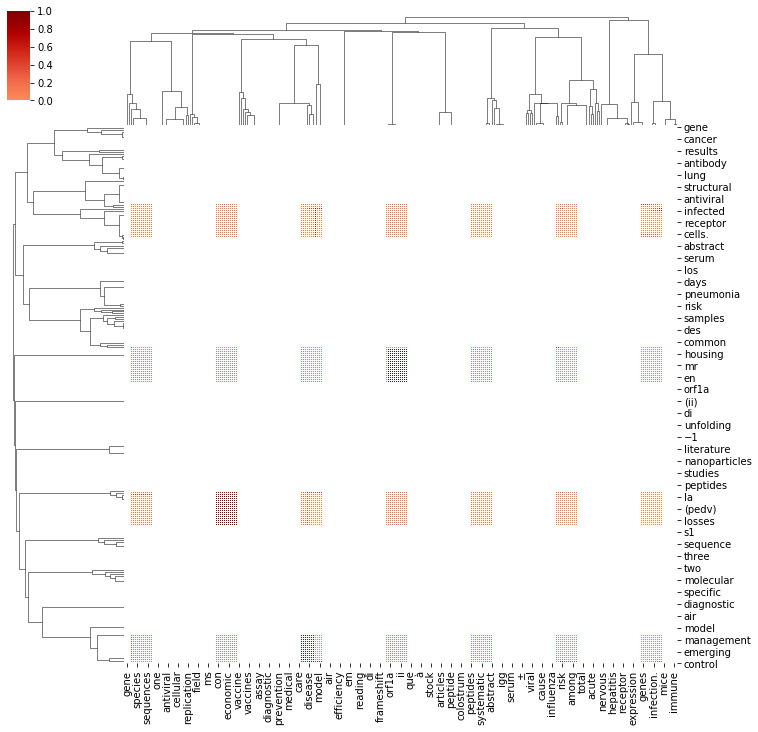

In [40]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [42]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel